In [ ]:
import os
import json
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image

#from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from matplotlib.pyplot import imread, imshow

#from keras.preprocessing.image import ImageDataGenerator
#from keras.layers import Dense, Dropout, Activation, Flatten
#from keras.layers import Conv2D, MaxPooling2D

import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
#import imageio
from nst_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 1

#%aimport 

SEED=1
random.seed(SEED)
np.random.seed(SEED)
tf.set_random_seed(SEED)

K.clear_session()
#K.set_image_data_format('channels_last')
#K.set_learning_phase(1)



In [2]:
print(tf.__version__)

1.14.0


In [3]:
sCS = "CSI2"
sesNum = "01"
runNum = "02"
sSes = "sess" + sesNum
sRun = "run" + runNum

stList = {}
last_sess = 3 # 15
last_run = 9 # 9

# Get list of stimuli pictures shown in each session in each run
for sNum in range(1, last_sess):
    sSes = "sess" + str(sNum).zfill(2)
    stList[sSes] = {}
    for rNum in range(1, last_run):
        sRun = "run" + str(rNum).zfill(2)
        stimulusDirPath = os.path.join("images","BOLD5000_Stimuli", "Stimuli_Presentation_Lists",sCS, sCS + "_" + sSes)
        #print(stimulusDirPath)
        stimulusListFilename = os.path.join(stimulusDirPath, "_".join([sCS, sSes, sRun]) + ".txt")
        #print(stimulusListFilename)
        with open(stimulusListFilename) as f:
            stList[sSes][sRun] = f.read().splitlines()


# Takes ~1 min
stimulusDirPath = os.path.join('images', 'BOLD5000_Stimuli', 'Scene_Stimuli', 'Presented_Stimuli')

x_images_path = {}
y_labels = {}
classes = {'ImageNet': 0, 'COCO': 1, 'Scene': 2}
for sess in stList:
    x_images_path[sess] = {}
    y_labels[sess] = {}
    for run in stList[sess]:
        x_images_path[sess][run] = []
        y_labels[sess][run] = []
        #print("sess: %s, run: %s" %(sess, run))
        labelList = []
        for imageFileName in stList[sess][run]:
            for (currDir, _, fileList) in os.walk(stimulusDirPath):
                currBaseDir = os.path.basename(currDir)
                for filename in fileList:
                    if filename in imageFileName:
                        fullFilename = os.path.join(currDir, filename)
                        #print(currDir)
                        x_images_path[sess][run].append(fullFilename)
                        # using directory path to determine class
                        labelList.append(classes.get(currDir.split('/')[-1]))
                        break

        y_labels[sess][run] = np.reshape(np.asarray(labelList), (1, -1))

#print(x_images_path)
print(y_labels['sess01']['run01'].shape)
print('done')

(1, 37)
done


In [4]:
print(y_labels['sess01']['run01'].shape)
print(y_labels['sess02']['run01'].shape)
print(len(stList['sess02']['run01']))

(1, 37)
(1, 37)
37


In [5]:
#print(x_images_path)
print(y_labels['sess01']['run01'].shape)
print(y_labels['sess01']['run01'])
print(len(x_images_path['sess01']['run02']))
print('done')

(1, 37)
[[0 0 1 1 1 1 2 1 0 1 1 0 1 2 1 0 0 2 1 2 1 0 0 2 0 1 1 0 2 2 0 1 1 0 1 0
  0]]
37
done


In [6]:
#print(x_images_path["sess04"]["run07"])
def unrollContentOutput(cOutput):
    m, n_H, n_W, n_C = cOutput.shape
    output = np.transpose(np.reshape(cOutput, (n_H * n_W, n_C)))
    return output

!mkdir -p stimulifeatures

tf.reset_default_graph()
#sess = tf.InteractiveSession()
#precompute content vectors from presented stimuli
#content_layer = 'conv4_2'
content_layer = 'avgpool5'
stimuli_features_dir = 'stimulifeatures'
with tf.Session() as ts:
    vmodel = load_vgg_model("imagenet-vgg-verydeep-19.mat")
    for sess in x_images_path:
        for run in x_images_path[sess]:
            #x_content = {sess: {run: []}}
            file_path= os.path.join(stimuli_features_dir, "_".join([sCS, sess, run]) + ".npy")
            print("file_path: %s" % file_path)
            print("sess: %s, run: %s" %(sess, run))
            contentList = []
            for img_path in x_images_path[sess][run]:
                #stImage = imread(cImage)
                img = image.load_img(img_path, target_size=(375, 375))
                x = image.img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
                #print("img_path: %s" % img_path)
                #print('Input image shape:', x.shape)
                #img_array = img_to_array(img)
                #stImage = imageio.imread(img_path)
                #print("img_path: %s" % img_path)
                #print(stImage.shape)
                #stImage = reshape_and_normalize_image(stImage)
                #stImage = np.reshape(stImage, (1, 375, 375, 3))
                ts.run(vmodel['input'].assign(x))
                #a_C = sess.run(vmodel)
                out = vmodel[content_layer]
                contentOut = ts.run(out)
                contentList.append(unrollContentOutput(contentOut))
            
            #x_content[sess][run] = np.asarray(contentList)
            contentArray = np.asarray(contentList)
            # shape is (35, 512, 144): num of pictures, channels, width*height
            #print(x_content[sess][run].shape)
            #x_content[sess][run].append(unrollContentOutput(contentOut))

            #np.save(file_path, x_content)
            np.save(file_path, contentArray)
            #del x_content

with tf.Session() as ts:
    vmodel = load_vgg_model("imagenet-vgg-verydeep-19.mat")
    img_path = './images/BOLD5000_Stimuli/Scene_Stimuli/Presented_Stimuli/ImageNet/n01833805_1411.JPEG'
    img = image.load_img(img_path, target_size=(375, 375))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    ts.run(vmodel['input'].assign(x))
    out = vmodel[content_layer]
    predictContentOut = ts.run(out)

print('done')

W1029 03:01:29.776621 140607309653760 deprecation_wrapper.py:119] From /home/ubuntu/fmriNet/nst_utils.py:127: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



file_path: stimulifeatures/CSI2_sess01_run01.npy
sess: sess01, run: run01
file_path: stimulifeatures/CSI2_sess01_run02.npy
sess: sess01, run: run02
file_path: stimulifeatures/CSI2_sess01_run03.npy
sess: sess01, run: run03
file_path: stimulifeatures/CSI2_sess01_run04.npy
sess: sess01, run: run04
file_path: stimulifeatures/CSI2_sess01_run05.npy
sess: sess01, run: run05
file_path: stimulifeatures/CSI2_sess01_run06.npy
sess: sess01, run: run06
file_path: stimulifeatures/CSI2_sess01_run07.npy
sess: sess01, run: run07
file_path: stimulifeatures/CSI2_sess01_run08.npy
sess: sess01, run: run08
file_path: stimulifeatures/CSI2_sess02_run01.npy
sess: sess02, run: run01
file_path: stimulifeatures/CSI2_sess02_run02.npy
sess: sess02, run: run02
file_path: stimulifeatures/CSI2_sess02_run03.npy
sess: sess02, run: run03
file_path: stimulifeatures/CSI2_sess02_run04.npy
sess: sess02, run: run04
file_path: stimulifeatures/CSI2_sess02_run05.npy
sess: sess02, run: run05
file_path: stimulifeatures/CSI2_sess02

In [7]:
file_path = os.path.join('stimulifeatures', 'CSI2_sess02_run04.npy')
#x_content = np.load(file_path, allow_pickle=True).item()
#print(x_content.get('sess01')['run01'].shape)
x_content = np.load(file_path, allow_pickle=True)
print(x_content.shape)

(37, 512, 144)


In [8]:
num_classes = 3

file_path = os.path.join('stimulifeatures', 'CSI2_sess01_run01.npy')
#x_content = np.load(file_path, allow_pickle=True).item()
#print(x_content.get('sess01')['run01'].shape)
x_content = np.load(file_path, allow_pickle=True)
print(x_content.shape)


# load data
#x_train = x_content.get('sess01')['run01']
x_train = x_content
y_train = np.transpose(y_labels['sess01']['run01'])
y_train = utils.to_categorical(y_train, num_classes)

file_path = os.path.join('stimulifeatures', 'CSI2_sess01_run02.npy')
#x_content = np.load(file_path, allow_pickle=True).item()
#print(x_content.get('sess01')['run02'].shape)
x_content = np.load(file_path, allow_pickle=True)
print(x_content.shape)

#x_test = x_content.get('sess01')['run02']
x_test = x_content
y_test = np.transpose(y_labels['sess01']['run02'])
y_test = utils.to_categorical(y_test, num_classes)


print(x_train.shape)
print(y_train.shape)
print(y_test.shape)


# each batch will be of 35 feature vectors of size 512 x 144 (35, 512, 144)


(37, 512, 144)
(37, 512, 144)
(37, 512, 144)
(37, 3)
(37, 3)


In [9]:
def dnn_classifier(input_shape, num_classes):
    X_input = Input(input_shape)
    X = Flatten()(X_input)
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(num_classes, activation='softmax')(X)
    model = Model(inputs = X_input, outputs = X, name='dnn_classifier')
    return model

def cnn_classifier(input_shape, num_classes):
    X_input = Input(input_shape)
    X = Flatten()(X)
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(num_classes, activation='softmax')(X)
    model = Model(inputs = X_input, outputs = X, name='dnn_classifier')
    return model

input_shape=[512, 144]
model = dnn_classifier(input_shape, num_classes)
#model = tf.keras.models.Sequential([
#    tf.keras.layers.Flatten(input_shape=[512, 144]),
#    tf.keras.layers.Dense(128, activation='relu'),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(num_classes, activation='softmax')
#])



W1029 03:25:37.682226 140607309653760 deprecation.py:506] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:

initial_epoch = 0


steps_per_epoch: 16
Epoch 1/15
350/350 [==============================] - 16s 46ms/step - loss: 0.8811 - acc: 0.6824 - val_loss: 0.1503 - val_acc: 0.8649
Epoch 2/15
350/350 [==============================] - 15s 44ms/step - loss: 0.3746 - acc: 0.8239 - val_loss: 0.1199 - val_acc: 1.0000
Epoch 3/15
350/350 [==============================] - 16s 45ms/step - loss: 0.3555 - acc: 0.8327 - val_loss: 0.1034 - val_acc: 1.0000
Epoch 4/15
350/350 [==============================] - 15s 43ms/step - loss: 0.3405 - acc: 0.8395 - val_loss: 0.0952 - val_acc: 1.0000
Epoch 5/15
350/350 [==============================] - 15s 43ms/step - loss: 0.3371 - acc: 0.8402 - val_loss: 0.0915 - val_acc: 1.0000
Epoch 6/15
350/350 [==============================] - 15s 43ms/step - loss: 0.3246 - acc: 0.8531 - val_loss: 0.0858 - val_acc: 1.0000
Epoch 7/15
350/350 [==============================] - 15s 43ms/step - loss: 0.3208 - acc: 0.8551 - val_loss: 0.0837 - val_acc: 1.0000
Epoch 8/15
350/350 [======================

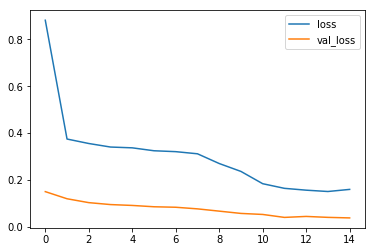

In [11]:

def loadFeatureVector(file_path):
    return np.load(file_path, allow_pickle=True)
    
def featureVectorLoader(x_images_path):
    #every file has 35 feature vectors (one batch)
    L = len(fileList)   
    while True:
        for sess in x_images_path:
            for run in x_images_path[sess]:
                file_path= os.path.join(stimuli_features_dir, "_".join([sCS, sess, run]) + ".npy")
                X = loadFeatureVector(file_path)
                Y = utils.to_categorical(np.transpose(y_labels['sess01']['run02']))
                yield (X,Y)
            

EPOCHS=15
#callbacks
#callbacks = [EarlyStopping(monitor='val_loss', patience=2),
#             ModelCheckpoint(filepath='weights.{epoch:02d}.h5', monitor='val_loss', verbose=1)]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train_history = model.fit(x=x_train, y=y_train, epochs=EPOCHS, callbacks=callbacks, batch_size=35, validation_data=(x_test, y_test))
#train_history = model.fit(x=x_train, y=y_train, epochs=EPOCHS, callbacks=callbacks, batch_size=35, validation_data=(x_test, y_test))
#train_history = model.fit_generator(featureVectorLoader(x_images_path), steps_per_epoch=5, epochs=EPOCHS, callbacks=callbacks) 
#train_history = model.fit_generator(featureVectorLoader(x_images_path), steps_per_epoch=5, epochs=EPOCHS, callbacks=callbacks, validation_data=(x_test, y_test)) 

steps_per_epoch = (last_sess - 1) * (last_run - 1)
print("steps_per_epoch: %s" % steps_per_epoch)
train_history = model.fit_generator(featureVectorLoader(x_images_path), steps_per_epoch=350, epochs=EPOCHS, validation_data=(x_test, y_test)) 


loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()



In [12]:


print("here")
x = unrollContentOutput(predictContentOut)
x = np.expand_dims(x, axis=0)
print('Input image shape:', x.shape)
print(model.predict(x))


here
Input image shape: (1, 512, 144)
[[0.9702159  0.02873369 0.00105043]]


In [ ]:
# Generate training and test set
# For milestone, first we try to train a classifier network using feature vectors from above
stimuli_features_dir = 'stimulifeatures'
#concatenate all feature vectors from all sessions/runs
x_all_list = []
for (currDir, _, fileList) in os.walk(stimuli_features_dir):
    currBaseDir = os.path.basename(currDir)
    for filename in fileList:
        fullFilename = os.path.join(currDir, filename)
        print(fullFilename)
        x_content = np.load(fullFilename, allow_pickle=True).item()
        for sess in x_content:
            for run in x_content[sess]:
                x_all_list.extend(x_content[sess][run])

print(x_all_list[0].shape)
print(x_all_list[1].shape)
print(x_all_list[43].shape)
x_all = np.asarray(x_all_list)
print(x_all.shape)

#for sess in x_images_path:
#    for run in x_images_path[sess]:
#        file_path = os.path.join('stimulifeatures', "_".join([sCS, sess, run]) + ".npy")
#        x_content = np.load(file_path)
#        print(x_content.keys())



In [ ]:

#for sess in x_images_path:
#    for run in x_images_path[sess]:
#        file_path = os.path.join('stimulifeatures', "_".join([sCS, sess, run]) + ".npy")
#        x_content = np.load(file_path)
#        print(x_content.keys())
            

#print(x_content['sess01']['run01'][0].shape)
#print(x_content['sess01']['run01'][3].shape)
#print(y_labels['sess01']['run01'].shape)




# create train and test test
x_all = []


# Load Data

In [ ]:
# load data
# split train test set
# del loaded data
# assert on expected shape
# assert x_train.shape == ()

#K.set_image_date_format('channels_last')

#mnist = tf.keras.datasets.mnist
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
#x_val, x_test = np.split(x_test, 2)
#y_val, y_test = np.split(y_test, 2)

#x_train, x_val, x_test = x_train / 255.0, x_val/255.0, x_train/255.0
#print(x_train.shape)

num_classes = 10

cifar10 = tf.keras.datasets.cifar10
(x_train, y_train_orig), (x_test_orig, y_test_orig) = cifar10.load_data()
x_val, x_test = np.split(x_test_orig, 2)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = utils.to_categorical(y_train_orig, num_classes)
y_test_1 = utils.to_categorical(y_test_orig, num_classes)

#y_val, y_test = np.split(y_test_1, 2)
del x_test_orig
del y_test_orig
del y_train_orig
del y_test_1

#x_train, x_val, x_test = x_train / 255.0, x_val/255.0, x_train/255.0

# Model

In [ ]:
VERSION = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(num_classes),
    tf.keras.layers.Activation('softmax')
])




#def classifer_cnn(input, name):
#    X = 
#    X = Conv2D()
#    return Model(input, X, name=name)
#input_shape =(28, 28, 3)

#model = tf.keras.models.Sequential([
#    tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
#                           activation='relu',
#                           input_shape=input_shape),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(128, activation='relu'),
#    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(10, activation='softmax')
#])

#model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
#                 activation='relu',
#                 input_shape=input_shape))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(Conv2D(64, (5, 5), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Flatten())
#model.add(Dense(1000, activation='relu'))
#model.add(Dense(num_classes, activation='softmax'))


!mkdir -p models
#%notebook -e models/{VERSION}.ipynb

#K.clear_session()
#K.set_session(tf.Session(config=))
#model = classifer_cnn(x_in, 'classifer_cnn')
#model.save(f'models/{VERSION}.architecture.h5')
#model.save('models/latest.architecture.h5')


# Train

In [ ]:
initial_epoch = 0



In [ ]:
EPOCHS=40
#K.set_image_date_format('channels_last')

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))


#callbacks
#tensorboard = Tensorboard(log_di='logs/' + VERSION)
#checkpoint_file_path = f'models/{VERSION}/{VERSION}.checkpoint.h5'
checkpoint_file_path = 'weights.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_file_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=2),
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                              patience=5, min_lr=0.001)
#learning_scheduler = LearningRateScheduler(scheduler)

#callbacks = [model_checkpoint, reduce_lr]
#callbacks = [model_checkpoint, reduce_lr, learning_scheduler]
#callbacks = [early_stopping, model_checkpoint]
#callbacks = [early_stopping]
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='weights.{epoch:02d}.h5', monitor='val_loss', verbose=1)]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#train_history = model.fit(x=x_train, y=y_train, epochs=EPOCHS, callbacks=callbacks, batch_size=256, validation_data=(x_val, y_val))
train_history = model.fit(x=x_train, y=y_train, epochs=EPOCHS, callbacks=callbacks, batch_size=256, validation_data=(x_test, y_test))


#plotter.losses(history)
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

#initial_epoch += EPOCHS
#model.save( f'models/{VERSION}.checkpoint.h5')

In [ ]:

#plotter.losses(history)
initial_epoch += 13
model.save( f'models/{VERSION}.checkpoint.h5')

#initial_epoch += EPOCHS
#model.save( f'models/{VERSION}/{VERSION}.checkpoint.h5')


In [ ]:



img_path = './images/BOLD5000_Stimuli/Scene_Stimuli/Presented_Stimuli/ImageNet/n01833805_1411.JPEG'
my_image = imread(img_path)
imshow(my_image)

img = image.load_img(img_path, target_size=(32, 32))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
print(model.predict(x))


In [ ]:

x_sample = x_train[120]
y_sample = y_train[120]
print(x_sample.shape)
imshow(x_sample)
print(y_sample)